In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#data slice for reviews
df=pd.read_json('reviews.json')   
temp=[i.strip() for i in df.iloc[:,3]]   

In [3]:
#delete punctuation
import string
exclude = set(string.punctuation)
reviews=[]
for i in range(len(temp)):
    reviews.append(''.join(ch for ch in temp[i] if ch not in exclude))  

In [4]:
#delete numbers
reviews1=[]
for i in range(len(temp)):

    reviews1.append(''.join(ch for ch in reviews[i] if not ch.isdigit()))  

In [5]:
#stem words
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.stem.lancaster import LancasterStemmer
stemmer = LancasterStemmer()
temp1=[]
temp2=[]
for i in range(len(reviews)):
    words = word_tokenize(reviews1[i])
    for word in words:
        temp1.append(stemmer.stem(word))
    temp2.append(temp1)
    temp1=[]

stemed_reviews=[]
for i in range(len(temp2)):
    a=' '.join(temp2[i])
    stemed_reviews.append(a)   

In [6]:
#sentiment analysis (pos vs neg vs neu)
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
neg=[]
pos=[]
neu=[]
compound=[]
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()
for sentence in reviews1:
    ss = sid.polarity_scores(sentence)
    neg.append(ss['neg'])
    pos.append(ss['pos'])
    neu.append(ss['neu'])
    compound.append(ss['compound'])

C:\Users\yuxia\Anaconda3\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\yuxia\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [7]:
#get review length
rating=df.iloc[:, 2].values
reviews=df.iloc[:, 3]   
review_lengths=reviews.apply(lambda r: len(r))

In [8]:
#add features to df
df['lenth']=review_lengths
df['neg']=neg
df['pos']=pos
df['neu']=neu
df['compound']=compound
df.replace(to_replace=df['Review'].values,value=stemed_reviews,inplace=True) 
df.head()

,Author,Date,Rating,Review,lenth,neg,pos,neu,compound
0,jon asri,2018-04-05,1,doa and thi item is not elig for return,45,0.335,0.000,0.665,-0.6166
1,Terry,2018-04-05,3,they ar bad light real bright light depress th...,326,0.056,0.172,0.772,0.7375
10,Tami Jones,2018-04-04,2,on of the two light i receiv doe not work i di...,104,0.000,0.000,1.000,0.0000
100,Amazon Customer,2018-01-04,4,nic produc for a good pric wish it had a set t...,175,0.000,0.225,0.775,0.8126
101,Carol C.,2018-01-03,1,i bought thes to us as a bik headlight my comm...,761,0.048,0.040,0.912,-0.5012


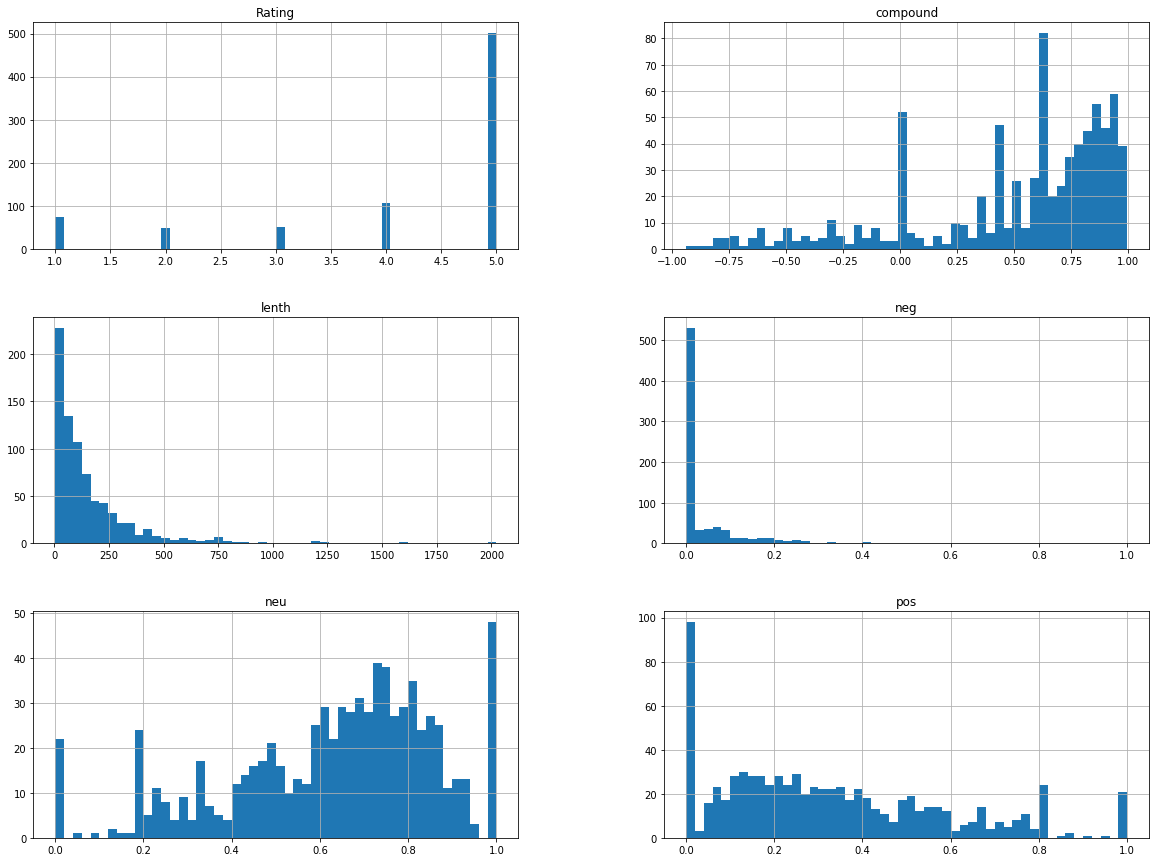

In [9]:
#features hist
df.hist(bins=50,figsize=(20,15))
plt.show()

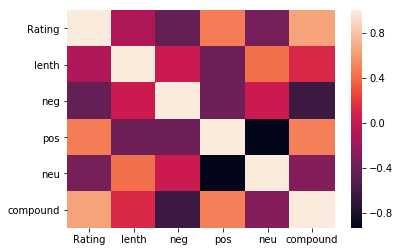

In [10]:
#features heat map
import seaborn as sns
df.corr()
sns.heatmap(df.corr())

Seems like all the features have some relationship with the score. Let's use all of them.

In [11]:
#get word bag
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(stop_words='english')
data = cv.fit_transform(stemed_reviews)
data=data.toarray()
word_bag_title=cv.get_feature_names()    

In [12]:
#creat dataframe of IV
df_x=pd.DataFrame(data)

Those words appear only once in the reviews should not  make sense. Let's delete them.

In [13]:
for j in range(1599):
    co_sum=0
    for i in range(781):
        co_sum=co_sum+df_x[j][i]
    if co_sum==1:
        df_x.pop(j)

In [14]:
#complete the dataframe of IV
df_x['lenth']=review_lengths
df_x['neg']=neg
df_x['pos']=pos
df_x['neu']=neu
df_x['compound']=compound
df_x.head()

,0,2,3,4,7,9,11,12,13,15,...,1589,1591,1593,1595,1597,lenth,neg,pos,neu,compound
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,45,0.335,0.000,0.665,-0.6166
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,326,0.056,0.172,0.772,0.7375
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,161,0.000,0.000,1.000,0.0000
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,227,0.000,0.225,0.775,0.8126
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,82,0.048,0.040,0.912,-0.5012


In [15]:
#get DV and IV
x = df_x
y = df.iloc[:, 2].values    

In [16]:
#splitting the dataset into the sraining set and test set
from sklearn.model_selection import train_test_split             
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 0)    

RandomForest Algorithm

In [17]:
from sklearn.ensemble import RandomForestClassifier         
RFclassifier=RandomForestClassifier(random_state=0)

In [18]:
#tuning parameters
from sklearn.model_selection import GridSearchCV
n_estimators_range=[10,100,500,1000]
max_depth_range=[None,5,8,15,30]
min_samples_split_range=[2,5,10,50,100]
min_samples_leaf_range=[1,2,5,10]
param_grid = dict(n_estimators=n_estimators_range, max_depth=max_depth_range, min_samples_leaf=min_samples_leaf_range, min_samples_split=min_samples_split_range)
grid = GridSearchCV(estimator=RFclassifier, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(x,y)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
#for mean, stdev, param in zip(means, stds, params):
    #print("%f (%f) with: %r" % (mean, stdev, param))
#(Result is too long on github)

Best: 0.702945 using {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500}


So we got the best parameters are max_depth:None, min_samples_leaf:1, min_samples_split:5 and n_estimators:500. And we can use these to get a new RF model with these parameters.

In [19]:
#predicting the test set result
RFclassifier=RandomForestClassifier(min_samples_leaf=1,min_samples_split=5,n_estimators=500,max_depth=None,random_state=0)
RFclassifier.fit(x_train,y_train)
y_pred=RFclassifier.predict(x_test)

In [20]:
#making the Confusion Matrix
from sklearn.metrics import confusion_matrix
RFcm=confusion_matrix(y_test,y_pred)
print(RFcm)

[[17  0  0  0  3]
 [ 3  1  0  0  8]
 [ 0  2  0  1  6]
 [ 0  1  1  1 23]
 [ 0  0  0  0 90]]


In [21]:
#AUC of RandomForest
RFaccuracy=RFcm.trace()/RFcm.sum()
print(RFaccuracy)

0.6942675159235668


Logistic Regression Algorithm

In [22]:
from sklearn.linear_model import LogisticRegression     
LRclassifier=LogisticRegression(random_state=0)

In [23]:
#tuning parameters
from sklearn.model_selection import GridSearchCV
penalty_range=['l1','l2']
C_range=[0.001,0.1,1,10,100]
param_grid = dict(penalty=penalty_range,C=C_range)
grid = GridSearchCV(estimator=LRclassifier, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(x,y)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.708067 using {'C': 1, 'penalty': 'l2'}
0.641485 (0.003071) with: {'C': 0.001, 'penalty': 'l1'}
0.641485 (0.003071) with: {'C': 0.001, 'penalty': 'l2'}
0.673496 (0.001628) with: {'C': 0.1, 'penalty': 'l1'}
0.701665 (0.003507) with: {'C': 0.1, 'penalty': 'l2'}
0.706786 (0.013618) with: {'C': 1, 'penalty': 'l1'}
0.708067 (0.013750) with: {'C': 1, 'penalty': 'l2'}
0.665813 (0.011581) with: {'C': 10, 'penalty': 'l1'}
0.687580 (0.008943) with: {'C': 10, 'penalty': 'l2'}
0.631242 (0.013059) with: {'C': 100, 'penalty': 'l1'}
0.667093 (0.021503) with: {'C': 100, 'penalty': 'l2'}


So we got the best parameters are C=1 and penalty=l2. And we can use these to get a new LR model with these parameters.

In [24]:
LRclassifier=LogisticRegression(C=1,penalty='l2',random_state=0)
LRclassifier.fit(x_train,y_train)
y_pred=LRclassifier.predict(x_test)

In [25]:
# making the Cofussion Matrix
from sklearn.metrics import confusion_matrix
LRcm=confusion_matrix(y_test,y_pred)
print(LRcm)

[[12  1  1  5  1]
 [ 3  2  3  1  3]
 [ 1  1  1  2  4]
 [ 2  0  1  5 18]
 [ 0  1  0  2 87]]


In [26]:
#AUC of Logistic Regression
LRaccuracy=LRcm.trace()/LRcm.sum()
print(LRaccuracy)

0.6815286624203821


SVM Algorithm

In [27]:
from sklearn.svm import SVC
SVCclassifier=SVC(random_state=0)

In [28]:
#tuning parameters
from sklearn.model_selection import GridSearchCV
C_range=[0.001,0.1,1,10,100]
kernel_range=['rbf','linear']
param_grid = dict(kernel=kernel_range,C=C_range)
grid = GridSearchCV(estimator=SVCclassifier, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(x,y)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.696543 using {'C': 0.1, 'kernel': 'linear'}
0.641485 (0.003071) with: {'C': 0.001, 'kernel': 'rbf'}
0.641485 (0.003071) with: {'C': 0.001, 'kernel': 'linear'}
0.641485 (0.003071) with: {'C': 0.1, 'kernel': 'rbf'}
0.696543 (0.009727) with: {'C': 0.1, 'kernel': 'linear'}
0.641485 (0.003071) with: {'C': 1, 'kernel': 'rbf'}
0.672215 (0.021932) with: {'C': 1, 'kernel': 'linear'}
0.627401 (0.009181) with: {'C': 10, 'kernel': 'rbf'}
0.629962 (0.008899) with: {'C': 10, 'kernel': 'linear'}
0.627401 (0.008343) with: {'C': 100, 'kernel': 'rbf'}
0.615877 (0.018985) with: {'C': 100, 'kernel': 'linear'}


So we got the best parameters are C=0.1 and kernel=linear. And we can use these to get a new SVC model with these parameters.

In [29]:
SVCclassifier=SVC(kernel='linear',C=0.1,random_state=0)
SVCclassifier.fit(x_train,y_train)
y_pred=SVCclassifier.predict(x_test)

In [30]:
# making the Cofussion Matrix
from sklearn.metrics import confusion_matrix
SVMcm=confusion_matrix(y_test,y_pred)
print(SVMcm)

[[13  1  2  1  3]
 [ 6  0  1  1  4]
 [ 1  1  0  0  7]
 [ 0  0  0  2 24]
 [ 0  1  0  1 88]]


In [31]:
#AUC of SVM
SVMaccuracy=SVMcm.trace()/SVMcm.sum()
print(SVMaccuracy)

0.6560509554140127


The final result is the Random Forest algorithm has the highest accuraccy, which is about 70%.